In [5]:
import numpy as np
import torch
import torch.nn as nn
import plotly.express as px

In [2]:
class PositionalEncoding2D(nn.Module):
    def __init__(self, channels):
        """
        :param channels: The last dimension of the tensor you want to apply pos emb to.
        """
        super().__init__()
        channels = int(np.ceil(channels/2))
        self.channels = channels
        inv_freq = 1. / (10000 ** (torch.arange(0, channels, 2).float() / channels))
        self.register_buffer('inv_freq', inv_freq)

    def forward(self, tensor):
        """
        :param tensor: A 4d tensor of size (batch_size, x, y, ch)
        :return: Positional Encoding Matrix of size (batch_size, x, y, ch)
        """
        if len(tensor.shape) != 4:
            raise RuntimeError("The input tensor has to be 4d!")
        batch_size, x, y, orig_ch = tensor.shape
        pos_x = torch.arange(x, device=tensor.device).type(self.inv_freq.type())
        pos_y = torch.arange(y, device=tensor.device).type(self.inv_freq.type())
        sin_inp_x = torch.einsum("i,j->ij", pos_x, self.inv_freq)
        sin_inp_y = torch.einsum("i,j->ij", pos_y, self.inv_freq)
        emb_x = torch.cat((sin_inp_x.sin(), sin_inp_x.cos()), dim=-1).unsqueeze(1)
        emb_y = torch.cat((sin_inp_y.sin(), sin_inp_y.cos()), dim=-1)
        emb = torch.zeros((x,y,self.channels*2),device=tensor.device).type(tensor.type())
        emb[:, :, :self.channels] = emb_x
        emb[:, :, self.channels:2*self.channels] = emb_y

        return emb[None, :, :, :orig_ch].repeat(batch_size, 1, 1, 1)


class PositionalEncodingPermute2D(nn.Module):
    def __init__(self, channels):
        """
        Accepts (batchsize, ch, x, y) instead of (batchsize, x, y, ch)      
        """
        super().__init__()
        self.penc = PositionalEncoding2D(channels)

    def forward(self, tensor):
        tensor = tensor.permute(0, 2, 3, 1)
        enc = self.penc(tensor)
        return enc.permute(0, 3, 1, 2)

In [17]:
N, C, H, W = 8, 384, 5, 5
tensor = torch.zeros((N, C, H, W))

emb = PositionalEncodingPermute2D(C)
out = emb(tensor)
print(out.shape)
print((out[1] == out[0]).all())

torch.Size([8, 16, 5, 5])
tensor(True)


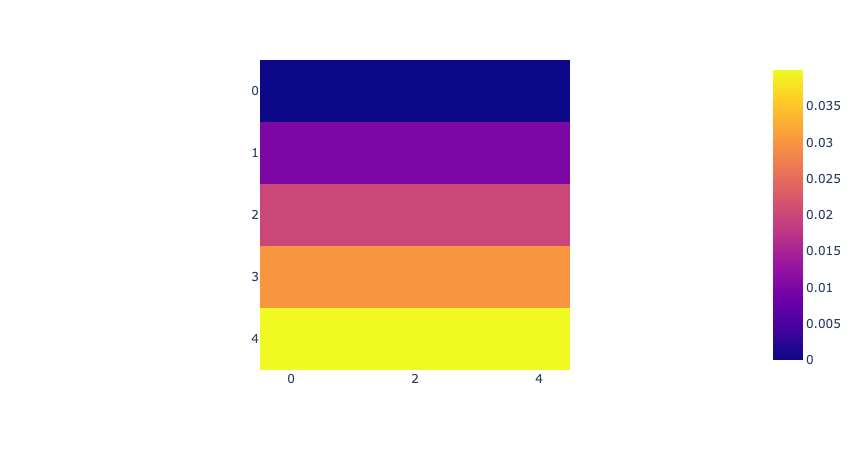

In [23]:
px.imshow(out[0, 2].numpy())

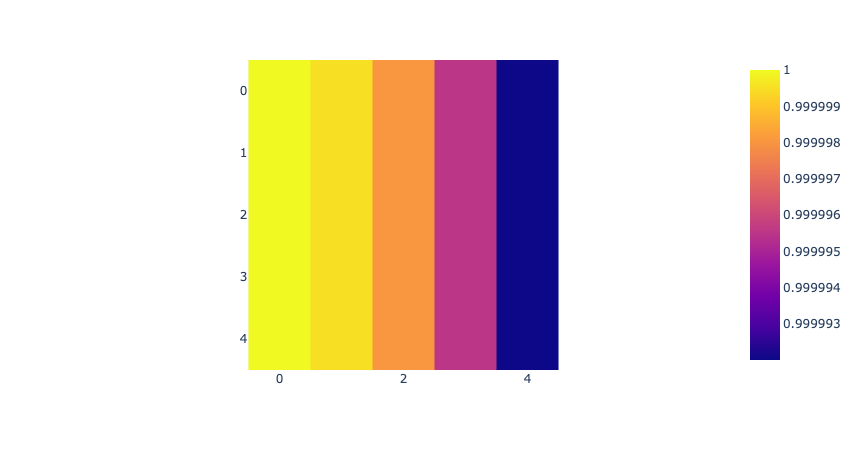

In [27]:
px.imshow(out[0, -1].numpy())